# ResNet Ablation Study

### 패키지 설처하기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

### GPU 장착 확인하기

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### cats_vs_dogs 데이터셋 불러오기

In [3]:
# 새 링크로 URL 수정
setattr(tfds.image_classification.cats_vs_dogs, '_URL',
        "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# 배치 크기 설정
BATCH_SIZE = 256

# 이미지 리사이즈와 정규화 전처리 함수 (224x224로 리사이즈)
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # 224x224로 리사이즈
    image = tf.cast(image, tf.float32) / 255.0  # [0, 1] 범위로 정규화
    return image, label

In [4]:
# 데이터셋 로드
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],  # 학습 및 검증용 데이터 분리
    as_supervised=True,
    shuffle_files=True,  # 파일을 셔플
    with_info=True,
)

# 전처리 적용 및 배치 크기 설정
ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

### feature 정보 확인하기

In [5]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요.
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


### 데이터 개수 확인하기

In [6]:
# 데이터의 개수도 확인해 봅시다.
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(73, shape=(), dtype=int64)
tf.Tensor(19, shape=(), dtype=int64)


In [7]:
# 배치 처리 전 데이터 개수 확인
#ds_train_unbatched = ds_train.unbatch()
#ds_test_unbatched = ds_test.unbatch()

#train_size = sum(1 for _ in ds_train_unbatched)
#test_size = sum(1 for _ in ds_test_unbatched)

#print(f"학습 데이터셋 샘플 개수: {train_size}")
#print(f"검증 데이터셋 샘플 개수: {test_size}")

### 정규화 코드 작성하기

In [8]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.
def normalize_and_resize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [9]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 클래스 구성요소 확인하기

In [10]:
ds_info.features["label"].num_classes

2

In [11]:
ds_info.features["label"].names

['cat', 'dog']

# 블록 구성하기

## ResNet 기본 블록 만들기
- 34와 50은 모두 conv block 이라고 불리는 블럭 구조를 각각 3,4,6,3개씩 반복해서 쌓은 형태의 공통점을 가지고 있다
- 34는 block은 3x3 kernel인 convolution layer로만 구성되어 있다
- 50은 1x1 convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지고 있다

## ResNet, PlainNet 차이
- ResNet은 skip connection과 residual network가 있다
- PlainNet은 skip connection이 없다

In [12]:
# ResNet 블록을 구성하는 함수 민들기
def build_resnet_block(x, filters, blocks, stride=1, is_plain=False, is_50=False):

    expansion = 4 if is_50 else 1
    # ResNet-50에서는 필터 확장을 위해 4를 사용, ResNet-34에서는 확장하지 않음

    for i in range(blocks): # 지정된 블록 수만큼 반복해서 Residual/Bottleneck Block을 쌓음
        stride_current = stride if i == 0 else 1 # 다운샘플링
        shortcut = x

        if is_50: # resnet-50 블록 구성
            
            # 1x1 합성곱으로 채널 수를 축소
            x = keras.layers.Conv2D(filters, kernel_size=1, strides=stride_current, padding='same', kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            # 3x3 합성곱으로 공간 정보를 학습
            x = keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            # 1x1 합성곱으로 채널 수를 확장
            x = keras.layers.Conv2D(filters * expansion, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x)
        
        else: # resnet-34 블록 구성
            
            # 3x3 합성곱으로 공간 정보를 학습
            x = keras.layers.Conv2D(filters, kernel_size=3, strides=stride_current, padding='same', kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            # 다시 3x3 합성곱 적용
            x = keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x)

        if not is_plain: # Residual 연결(resnet 34, 50에만 사용한다)
            if stride_current != 1 or keras.backend.int_shape(shortcut)[-1] != filters * expansion:
                shortcut = keras.layers.Conv2D(filters * expansion, kernel_size=1, strides=stride_current, padding='same', kernel_initializer='he_normal')(shortcut)
                shortcut = keras.layers.BatchNormalization()(shortcut)
            x = keras.layers.Add()([x, shortcut])

        x = keras.layers.Activation('relu')(x)

    return x

In [13]:
def build_resnet(input_shape, num_classes, is_50=False, is_plain=False):

    inputs = keras.layers.Input(shape=input_shape)

    # 초기 레이어
    x = keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', kernel_initializer='he_normal',name='input_layer')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    if is_50: # ResNet-50 블록 수
        layers = [3, 4, 6, 3]
        filters = [64, 128, 256, 512]
    else: # ResNet-34 블록 수
        layers = [3, 4, 6, 3]
        filters = [64, 128, 256, 512]

    # 각 스테이지별로 블록을 쌓습니다.
    for i in range(len(layers)):
        stride = 1 if i == 0 else 2
        x = build_resnet_block(x, filters=filters[i], blocks=layers[i], stride=stride, is_plain=is_plain, is_50=is_50)

    # 최종 레이어
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, activation='softmax')(x)

    # 모델 이름 설정
    model_depth = 50 if is_50 else 34
    model_type = 'plainnet' if is_plain else 'resnet'
    model_name = f"{model_type}_{model_depth}"

    model = keras.models.Model(inputs=inputs, outputs=x, name=model_name)

    return model

In [39]:
def build_plainnet(input_shape, num_classes, is_50=False):
    
    return build_resnet(input_shape, num_classes, is_50=is_50, is_plain=True)

### ResNet-34

In [15]:
# 모델 빌드
resnet_34 = build_resnet(input_shape=(224, 224, 3), num_classes=2, is_50=False, is_plain=False)
resnet_34.summary()

Model: "resnet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_layer (Conv2D)            (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         input_layer[0][0]                
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
__________________________________________________________________________________________

In [16]:
# resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
# resnet_34.summary()

### ResNet-50

In [17]:
# 모델 빌드
resnet_50 = build_resnet(input_shape=(224, 224, 3), num_classes=2, is_50=False, is_plain=False)
resnet_50.summary()

Model: "resnet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_layer (Conv2D)            (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 112, 112, 64) 256         input_layer[0][0]                
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

In [18]:
# resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
# resnet_50.summary()

### epoch 설정하기

In [19]:
EPOCH = 15

### resnet 34 학습하기

In [20]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


20/73 [=======>......................] - ETA: 1:07 - loss: 0.7566 - accuracy: 0.5641

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:02 - loss: 0.7413 - accuracy: 0.5708

25/73 [=========>....................] - ETA: 1:01 - loss: 0.7373 - accuracy: 0.5745

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 49s - loss: 0.7116 - accuracy: 0.5846

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6841 - accuracy: 0.6003

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.6829 - accuracy: 0.6009

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 13s - loss: 0.6825 - accuracy: 0.6011

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6793 - accuracy: 0.6030

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6781 - accuracy: 0.6036

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6755 - accuracy: 0.6059

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 123s 1s/step - loss: 0.6755 - accuracy: 0.6059 - val_loss: 1.1172 - val_accuracy: 0.5105
Epoch 2/15
21/73 [=======>......................] - ETA: 1:08 - loss: 0.6194 - accuracy: 0.6510

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:05 - loss: 0.6171 - accuracy: 0.6543

26/73 [=========>....................] - ETA: 1:02 - loss: 0.6171 - accuracy: 0.6546

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.6133 - accuracy: 0.6561

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6107 - accuracy: 0.6580

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.6105 - accuracy: 0.6580

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6103 - accuracy: 0.6586

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6084 - accuracy: 0.6611

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6075 - accuracy: 0.6623

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 104s 1s/step - loss: 0.6075 - accuracy: 0.6623 - val_loss: 0.6988 - val_accuracy: 0.5593
Epoch 3/15
20/73 [=======>......................] - ETA: 1:10 - loss: 0.5813 - accuracy: 0.6979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:05 - loss: 0.5793 - accuracy: 0.6979

25/73 [=========>....................] - ETA: 1:03 - loss: 0.5791 - accuracy: 0.6984

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.5765 - accuracy: 0.6999

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.5695 - accuracy: 0.7049

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.5685 - accuracy: 0.7056

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.5689 - accuracy: 0.7058

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.5676 - accuracy: 0.7073

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.5673 - accuracy: 0.7076

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.7087

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 107s 1s/step - loss: 0.5662 - accuracy: 0.7087 - val_loss: 0.7877 - val_accuracy: 0.5340
Epoch 4/15
21/73 [=======>......................] - ETA: 1:09 - loss: 0.5316 - accuracy: 0.7390

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:05 - loss: 0.5306 - accuracy: 0.7367

26/73 [=========>....................] - ETA: 1:02 - loss: 0.5317 - accuracy: 0.7354

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.5259 - accuracy: 0.7405

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.5181 - accuracy: 0.7478

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 13s - loss: 0.5170 - accuracy: 0.7491

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.5168 - accuracy: 0.7492

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.5150 - accuracy: 0.7508

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.5144 - accuracy: 0.7510

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5117 - accuracy: 0.7533

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 105s 1s/step - loss: 0.5117 - accuracy: 0.7533 - val_loss: 0.7131 - val_accuracy: 0.6098
Epoch 5/15
21/73 [=======>......................] - ETA: 1:09 - loss: 0.4720 - accuracy: 0.7801

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:03 - loss: 0.4695 - accuracy: 0.7803

26/73 [=========>....................] - ETA: 1:02 - loss: 0.4712 - accuracy: 0.7788

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.4637 - accuracy: 0.7846

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.4537 - accuracy: 0.7948

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 13s - loss: 0.4526 - accuracy: 0.7953

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.4522 - accuracy: 0.7953

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.4508 - accuracy: 0.7964

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.4501 - accuracy: 0.7968

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.4478 - accuracy: 0.7991

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 105s 1s/step - loss: 0.4478 - accuracy: 0.7991 - val_loss: 0.5992 - val_accuracy: 0.6984
Epoch 6/15
21/73 [=======>......................] - ETA: 1:09 - loss: 0.3998 - accuracy: 0.8255

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:03 - loss: 0.4013 - accuracy: 0.8239

26/73 [=========>....................] - ETA: 1:02 - loss: 0.4044 - accuracy: 0.8218

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.3953 - accuracy: 0.8275

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.3871 - accuracy: 0.8326

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.3859 - accuracy: 0.8339

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.3839 - accuracy: 0.8358

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.3815 - accuracy: 0.8371

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.3808 - accuracy: 0.8373

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.3759 - accuracy: 0.8408

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 104s 1s/step - loss: 0.3759 - accuracy: 0.8408 - val_loss: 1.2922 - val_accuracy: 0.5396
Epoch 7/15
21/73 [=======>......................] - ETA: 1:08 - loss: 0.3370 - accuracy: 0.8681

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:04 - loss: 0.3298 - accuracy: 0.8730

26/73 [=========>....................] - ETA: 1:01 - loss: 0.3273 - accuracy: 0.8747

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 49s - loss: 0.3181 - accuracy: 0.8796

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.3050 - accuracy: 0.8848

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.3041 - accuracy: 0.8851

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.3028 - accuracy: 0.8857

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.3014 - accuracy: 0.8859

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.3001 - accuracy: 0.8869

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.8901

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 104s 1s/step - loss: 0.2944 - accuracy: 0.8901 - val_loss: 2.7670 - val_accuracy: 0.4933
Epoch 8/15
21/73 [=======>......................] - ETA: 1:08 - loss: 0.2380 - accuracy: 0.9191

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:03 - loss: 0.2395 - accuracy: 0.9175

26/73 [=========>....................] - ETA: 1:02 - loss: 0.2398 - accuracy: 0.9169

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.2300 - accuracy: 0.9221

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.2142 - accuracy: 0.9282

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 13s - loss: 0.2133 - accuracy: 0.9280

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.2143 - accuracy: 0.9272

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.2143 - accuracy: 0.9263

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.2137 - accuracy: 0.9264

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.2115 - accuracy: 0.9272

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 105s 1s/step - loss: 0.2115 - accuracy: 0.9272 - val_loss: 0.8524 - val_accuracy: 0.6728
Epoch 9/15
21/73 [=======>......................] - ETA: 1:09 - loss: 0.1769 - accuracy: 0.9379

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:04 - loss: 0.1710 - accuracy: 0.9422

26/73 [=========>....................] - ETA: 1:02 - loss: 0.1691 - accuracy: 0.9435

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.1655 - accuracy: 0.9445

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.1565 - accuracy: 0.9488

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.1551 - accuracy: 0.9495

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 13s - loss: 0.1540 - accuracy: 0.9501

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.1503 - accuracy: 0.9520

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.1495 - accuracy: 0.9524

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9539

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 105s 1s/step - loss: 0.1458 - accuracy: 0.9539 - val_loss: 2.1649 - val_accuracy: 0.5404
Epoch 10/15
21/73 [=======>......................] - ETA: 1:09 - loss: 0.1097 - accuracy: 0.9678

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:05 - loss: 0.1103 - accuracy: 0.9670

26/73 [=========>....................] - ETA: 1:02 - loss: 0.1150 - accuracy: 0.9644

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.1071 - accuracy: 0.9683

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.0940 - accuracy: 0.9737

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 13s - loss: 0.0924 - accuracy: 0.9744

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.0922 - accuracy: 0.9745

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.0910 - accuracy: 0.9750

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.0902 - accuracy: 0.9754

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9764

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 104s 1s/step - loss: 0.0874 - accuracy: 0.9764 - val_loss: 0.8133 - val_accuracy: 0.7132
Epoch 11/15
21/73 [=======>......................] - ETA: 1:08 - loss: 0.0696 - accuracy: 0.9827

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:04 - loss: 0.0666 - accuracy: 0.9834

26/73 [=========>....................] - ETA: 1:02 - loss: 0.0668 - accuracy: 0.9835

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.0595 - accuracy: 0.9863

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.0525 - accuracy: 0.9890

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.0521 - accuracy: 0.9890

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.0515 - accuracy: 0.9892

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.0524 - accuracy: 0.9887

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.0524 - accuracy: 0.9889

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9895

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 104s 1s/step - loss: 0.0503 - accuracy: 0.9895 - val_loss: 1.3492 - val_accuracy: 0.6584
Epoch 12/15
21/73 [=======>......................] - ETA: 1:08 - loss: 0.0313 - accuracy: 0.9937

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:03 - loss: 0.0308 - accuracy: 0.9942

26/73 [=========>....................] - ETA: 1:02 - loss: 0.0323 - accuracy: 0.9935

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.0301 - accuracy: 0.9948

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.0265 - accuracy: 0.9956

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 13s - loss: 0.0260 - accuracy: 0.9958

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.0259 - accuracy: 0.9958

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.0254 - accuracy: 0.9959

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.0252 - accuracy: 0.9960

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9962

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 105s 1s/step - loss: 0.0241 - accuracy: 0.9962 - val_loss: 1.4781 - val_accuracy: 0.6617
Epoch 13/15
20/73 [=======>......................] - ETA: 1:10 - loss: 0.0158 - accuracy: 0.9980

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:04 - loss: 0.0146 - accuracy: 0.9984

25/73 [=========>....................] - ETA: 1:03 - loss: 0.0148 - accuracy: 0.9984

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.0128 - accuracy: 0.9989

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.0113 - accuracy: 0.9992

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.0111 - accuracy: 0.9992

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.0109 - accuracy: 0.9993

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.0107 - accuracy: 0.9993

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.0106 - accuracy: 0.9993

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9994

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 104s 1s/step - loss: 0.0103 - accuracy: 0.9994 - val_loss: 1.2640 - val_accuracy: 0.6952
Epoch 14/15
21/73 [=======>......................] - ETA: 1:08 - loss: 0.0073 - accuracy: 0.9993

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:03 - loss: 0.0069 - accuracy: 0.9994

26/73 [=========>....................] - ETA: 1:02 - loss: 0.0068 - accuracy: 0.9994

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.0060 - accuracy: 0.9996

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.0051 - accuracy: 0.9997

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.0052 - accuracy: 0.9997

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 13s - loss: 0.0051 - accuracy: 0.9998

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.0050 - accuracy: 0.9998

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.0050 - accuracy: 0.9998

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9998

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 105s 1s/step - loss: 0.0049 - accuracy: 0.9998 - val_loss: 1.2437 - val_accuracy: 0.7014
Epoch 15/15
21/73 [=======>......................] - ETA: 1:09 - loss: 0.0033 - accuracy: 1.0000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:03 - loss: 0.0033 - accuracy: 1.0000

26/73 [=========>....................] - ETA: 1:02 - loss: 0.0033 - accuracy: 1.0000

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.0033 - accuracy: 1.0000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.0030 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 13s - loss: 0.0030 - accuracy: 1.0000

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.0030 - accuracy: 0.9999

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.0030 - accuracy: 0.9999

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.0030 - accuracy: 0.9999

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9999

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 104s 1s/step - loss: 0.0030 - accuracy: 0.9999 - val_loss: 1.1280 - val_accuracy: 0.7182


### resnet 50 학습하기

In [21]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
21/73 [=======>......................] - ETA: 1:08 - loss: 0.7037 - accuracy: 0.5616

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:05 - loss: 0.7001 - accuracy: 0.5643

26/73 [=========>....................] - ETA: 1:02 - loss: 0.6978 - accuracy: 0.5675

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.6899 - accuracy: 0.5778

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6731 - accuracy: 0.5964

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 13s - loss: 0.6714 - accuracy: 0.5981

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6711 - accuracy: 0.5984

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6691 - accuracy: 0.6010

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6678 - accuracy: 0.6024

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.6045

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 113s 1s/step - loss: 0.6666 - accuracy: 0.6045 - val_loss: 0.6958 - val_accuracy: 0.5696
Epoch 2/15
21/73 [=======>......................] - ETA: 1:09 - loss: 0.6333 - accuracy: 0.6419

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:04 - loss: 0.6286 - accuracy: 0.6486

26/73 [=========>....................] - ETA: 1:02 - loss: 0.6302 - accuracy: 0.6469

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.6299 - accuracy: 0.6473

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6187 - accuracy: 0.6573

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.6180 - accuracy: 0.6578

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6181 - accuracy: 0.6587

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6168 - accuracy: 0.6600

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6160 - accuracy: 0.6603

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6141 - accuracy: 0.6621

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 105s 1s/step - loss: 0.6141 - accuracy: 0.6621 - val_loss: 0.7682 - val_accuracy: 0.5230
Epoch 3/15
21/73 [=======>......................] - ETA: 1:09 - loss: 0.5877 - accuracy: 0.6873

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:03 - loss: 0.5848 - accuracy: 0.6909

26/73 [=========>....................] - ETA: 1:02 - loss: 0.5861 - accuracy: 0.6904

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.5844 - accuracy: 0.6908

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.5740 - accuracy: 0.6968

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.5728 - accuracy: 0.6977

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 13s - loss: 0.5730 - accuracy: 0.6980

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.5712 - accuracy: 0.7000

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.5704 - accuracy: 0.7005

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5691 - accuracy: 0.7023

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 104s 1s/step - loss: 0.5691 - accuracy: 0.7023 - val_loss: 0.8937 - val_accuracy: 0.5224
Epoch 4/15
21/73 [=======>......................] - ETA: 1:08 - loss: 0.5305 - accuracy: 0.7390

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:04 - loss: 0.5321 - accuracy: 0.7358

26/73 [=========>....................] - ETA: 1:02 - loss: 0.5316 - accuracy: 0.7363

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.5294 - accuracy: 0.7364

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.5175 - accuracy: 0.7476

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 13s - loss: 0.5173 - accuracy: 0.7478

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.5171 - accuracy: 0.7484

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.5159 - accuracy: 0.7490

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.5151 - accuracy: 0.7496

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5130 - accuracy: 0.7499

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 104s 1s/step - loss: 0.5130 - accuracy: 0.7499 - val_loss: 1.0513 - val_accuracy: 0.5105
Epoch 5/15
21/73 [=======>......................] - ETA: 1:09 - loss: 0.4866 - accuracy: 0.7693

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:03 - loss: 0.4817 - accuracy: 0.7722

26/73 [=========>....................] - ETA: 1:02 - loss: 0.4826 - accuracy: 0.7719

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.4734 - accuracy: 0.7780

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.4634 - accuracy: 0.7834

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.4619 - accuracy: 0.7847

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.4602 - accuracy: 0.7870

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.4572 - accuracy: 0.7899

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.4553 - accuracy: 0.7912

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 105s 1s/step - loss: 0.4553 - accuracy: 0.7912 - val_loss: 0.6196 - val_accuracy: 0.6668
Epoch 6/15
21/73 [=======>......................] - ETA: 1:09 - loss: 0.4109 - accuracy: 0.8220

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:03 - loss: 0.4067 - accuracy: 0.8256

26/73 [=========>....................] - ETA: 1:02 - loss: 0.4086 - accuracy: 0.8241

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.4029 - accuracy: 0.8266

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.3878 - accuracy: 0.8352

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.3863 - accuracy: 0.8361

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.3846 - accuracy: 0.8372

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.3844 - accuracy: 0.8373

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.3839 - accuracy: 0.8373

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.3808 - accuracy: 0.8387

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 105s 1s/step - loss: 0.3808 - accuracy: 0.8387 - val_loss: 0.6909 - val_accuracy: 0.6606
Epoch 7/15
21/73 [=======>......................] - ETA: 1:08 - loss: 0.3406 - accuracy: 0.8653

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:05 - loss: 0.3370 - accuracy: 0.8672

26/73 [=========>....................] - ETA: 1:02 - loss: 0.3382 - accuracy: 0.8658

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.3392 - accuracy: 0.8632

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.3203 - accuracy: 0.8753

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 13s - loss: 0.3188 - accuracy: 0.8760

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.3187 - accuracy: 0.8759

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.3172 - accuracy: 0.8770

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.3157 - accuracy: 0.8778

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.8815

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 105s 1s/step - loss: 0.3097 - accuracy: 0.8815 - val_loss: 2.0710 - val_accuracy: 0.5097
Epoch 8/15
21/73 [=======>......................] - ETA: 1:09 - loss: 0.2630 - accuracy: 0.9048

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:03 - loss: 0.2601 - accuracy: 0.9056

26/73 [=========>....................] - ETA: 1:02 - loss: 0.2606 - accuracy: 0.9050

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.2520 - accuracy: 0.9095

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.2335 - accuracy: 0.9190

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 13s - loss: 0.2327 - accuracy: 0.9195

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.2320 - accuracy: 0.9197

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.2323 - accuracy: 0.9187

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.2318 - accuracy: 0.9188

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.2302 - accuracy: 0.9195

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 104s 1s/step - loss: 0.2302 - accuracy: 0.9195 - val_loss: 2.4418 - val_accuracy: 0.5086
Epoch 9/15
21/73 [=======>......................] - ETA: 1:09 - loss: 0.2028 - accuracy: 0.9260

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:04 - loss: 0.2056 - accuracy: 0.9231

26/73 [=========>....................] - ETA: 1:02 - loss: 0.2042 - accuracy: 0.9237

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.1966 - accuracy: 0.9283

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.1979 - accuracy: 0.9257

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.1968 - accuracy: 0.9263

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.1944 - accuracy: 0.9280

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.1914 - accuracy: 0.9296

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.1903 - accuracy: 0.9301

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9330

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 107s 1s/step - loss: 0.1848 - accuracy: 0.9330 - val_loss: 2.6892 - val_accuracy: 0.5123
Epoch 10/15
21/73 [=======>......................] - ETA: 1:08 - loss: 0.1067 - accuracy: 0.9767

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:05 - loss: 0.1053 - accuracy: 0.9779

26/73 [=========>....................] - ETA: 1:02 - loss: 0.1058 - accuracy: 0.9781

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.1007 - accuracy: 0.9794

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.0935 - accuracy: 0.9792

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.0927 - accuracy: 0.9794

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.0943 - accuracy: 0.9783

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.0947 - accuracy: 0.9776

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.0947 - accuracy: 0.9774

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0927 - accuracy: 0.9778

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 105s 1s/step - loss: 0.0927 - accuracy: 0.9778 - val_loss: 0.9829 - val_accuracy: 0.6793
Epoch 11/15
21/73 [=======>......................] - ETA: 1:09 - loss: 0.0929 - accuracy: 0.9699

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:05 - loss: 0.0923 - accuracy: 0.9694

26/73 [=========>....................] - ETA: 1:02 - loss: 0.0951 - accuracy: 0.9680

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.0924 - accuracy: 0.9690

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.0818 - accuracy: 0.9748

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.0807 - accuracy: 0.9752

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.0792 - accuracy: 0.9759

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.0768 - accuracy: 0.9770

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.0759 - accuracy: 0.9773

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9787

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 104s 1s/step - loss: 0.0720 - accuracy: 0.9787 - val_loss: 1.4395 - val_accuracy: 0.6354
Epoch 12/15
21/73 [=======>......................] - ETA: 1:09 - loss: 0.0279 - accuracy: 0.9968

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:03 - loss: 0.0266 - accuracy: 0.9973

26/73 [=========>....................] - ETA: 1:02 - loss: 0.0265 - accuracy: 0.9974

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.0252 - accuracy: 0.9975

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.0218 - accuracy: 0.9981

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.0216 - accuracy: 0.9980

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.0215 - accuracy: 0.9980

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.0211 - accuracy: 0.9981

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.0209 - accuracy: 0.9982

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 0.9982

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 105s 1s/step - loss: 0.0203 - accuracy: 0.9982 - val_loss: 1.8202 - val_accuracy: 0.6189
Epoch 13/15
21/73 [=======>......................] - ETA: 1:08 - loss: 0.0116 - accuracy: 0.9996

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:03 - loss: 0.0111 - accuracy: 0.9997

26/73 [=========>....................] - ETA: 1:01 - loss: 0.0111 - accuracy: 0.9997

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.0114 - accuracy: 0.9992

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.0094 - accuracy: 0.9995

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.0094 - accuracy: 0.9995

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.0092 - accuracy: 0.9995

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.0090 - accuracy: 0.9995

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.0089 - accuracy: 0.9995

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9996

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 104s 1s/step - loss: 0.0087 - accuracy: 0.9996 - val_loss: 1.5185 - val_accuracy: 0.6539
Epoch 14/15
21/73 [=======>......................] - ETA: 1:08 - loss: 0.0061 - accuracy: 1.0000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:03 - loss: 0.0059 - accuracy: 1.0000

26/73 [=========>....................] - ETA: 1:02 - loss: 0.0059 - accuracy: 1.0000

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.0062 - accuracy: 0.9999

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.0063 - accuracy: 0.9999

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 13s - loss: 0.0063 - accuracy: 0.9999

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.0062 - accuracy: 0.9999

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.0061 - accuracy: 0.9999

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9999

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 104s 1s/step - loss: 0.0060 - accuracy: 0.9999 - val_loss: 1.3975 - val_accuracy: 0.6752
Epoch 15/15
21/73 [=======>......................] - ETA: 1:07 - loss: 0.0039 - accuracy: 1.0000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:02 - loss: 0.0037 - accuracy: 1.0000

26/73 [=========>....................] - ETA: 1:01 - loss: 0.0037 - accuracy: 1.0000

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 50s - loss: 0.0036 - accuracy: 1.0000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.0034 - accuracy: 0.9999

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 14s - loss: 0.0034 - accuracy: 0.9999

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.0034 - accuracy: 0.9999

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.0034 - accuracy: 0.9999

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.0033 - accuracy: 0.9999

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9999

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 104s 1s/step - loss: 0.0033 - accuracy: 0.9999 - val_loss: 1.2096 - val_accuracy: 0.6993


## Plainnet 기본 블록 만들기

In [40]:
# PlainNet-34 모델
plainnet_34 = build_plainnet(input_shape=(224, 224, 3), num_classes=2, is_50=False)
plainnet_34.summary()

Model: "plainnet_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
input_layer (Conv2D)         (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_72 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_66 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_73 (Batc (None, 56, 56, 64)        

In [41]:
# plainnet_34 = build_plainnet(input_shape=(32, 32,3), num_layers=34)
# plainnet_34.summary()

In [42]:
# PlainNet-50 모델
plainnet_50 = build_plainnet(input_shape=(224, 224, 3), num_classes=2, is_50=False)
plainnet_50.summary()

Model: "plainnet_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
input_layer (Conv2D)         (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_105 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_99 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_106 (Bat (None, 56, 56, 64)        

In [43]:
# plainnet_50 = build_plainnet(input_shape=(32, 32,3), num_layers=50)
# plainnet_50.summary()

In [44]:
plainnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plainnet_34.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


21/73 [=======>......................] - ETA: 1:03 - loss: 0.6954 - accuracy: 0.5292

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 58s - loss: 0.6954 - accuracy: 0.5283

26/73 [=========>....................] - ETA: 57s - loss: 0.6956 - accuracy: 0.5275

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6945 - accuracy: 0.5304

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6926 - accuracy: 0.5333

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6927 - accuracy: 0.5333

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6928 - accuracy: 0.5328

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6923 - accuracy: 0.5345

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5351

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 107s 1s/step - loss: 0.6922 - accuracy: 0.5351 - val_loss: 0.7018 - val_accuracy: 0.4901
Epoch 2/15
21/73 [=======>......................] - ETA: 1:06 - loss: 0.6872 - accuracy: 0.5504

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:01 - loss: 0.6870 - accuracy: 0.5519

26/73 [=========>....................] - ETA: 59s - loss: 0.6872 - accuracy: 0.5505 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.6853 - accuracy: 0.5544

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6848 - accuracy: 0.5565

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6848 - accuracy: 0.5568

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6849 - accuracy: 0.5563

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6846 - accuracy: 0.5572

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6846 - accuracy: 0.5572

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5574

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.6852 - accuracy: 0.5574 - val_loss: 0.7242 - val_accuracy: 0.4901
Epoch 3/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6836 - accuracy: 0.5593

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6838 - accuracy: 0.5611

26/73 [=========>....................] - ETA: 59s - loss: 0.6839 - accuracy: 0.5592 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.6830 - accuracy: 0.5625

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


60/73 [=======================>......] - ETA: 16s - loss: 0.6824 - accuracy: 0.5620

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6824 - accuracy: 0.5621

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6826 - accuracy: 0.5617

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6822 - accuracy: 0.5627

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6822 - accuracy: 0.5622

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.5611

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.6827 - accuracy: 0.5611 - val_loss: 0.7382 - val_accuracy: 0.4903
Epoch 4/15
21/73 [=======>......................] - ETA: 1:06 - loss: 0.6814 - accuracy: 0.5670

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:01 - loss: 0.6816 - accuracy: 0.5675

26/73 [=========>....................] - ETA: 59s - loss: 0.6824 - accuracy: 0.5672 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.6805 - accuracy: 0.5682

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6801 - accuracy: 0.5719

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6799 - accuracy: 0.5725

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6798 - accuracy: 0.5721

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6797 - accuracy: 0.5726

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6795 - accuracy: 0.5735

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.5720

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.6799 - accuracy: 0.5720 - val_loss: 0.7194 - val_accuracy: 0.4972
Epoch 5/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6812 - accuracy: 0.5634

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6821 - accuracy: 0.5656

26/73 [=========>....................] - ETA: 59s - loss: 0.6822 - accuracy: 0.5664 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.6801 - accuracy: 0.5685

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6773 - accuracy: 0.5745

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6777 - accuracy: 0.5737

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6777 - accuracy: 0.5737

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6775 - accuracy: 0.5737

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6774 - accuracy: 0.5738

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.5730

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.6774 - accuracy: 0.5730 - val_loss: 0.6904 - val_accuracy: 0.5408
Epoch 6/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6763 - accuracy: 0.5755

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6766 - accuracy: 0.5766

26/73 [=========>....................] - ETA: 59s - loss: 0.6771 - accuracy: 0.5760 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6755 - accuracy: 0.5806

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6742 - accuracy: 0.5856

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6747 - accuracy: 0.5856

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6747 - accuracy: 0.5851

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6742 - accuracy: 0.5858

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6742 - accuracy: 0.5858

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6739 - accuracy: 0.5851

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6739 - accuracy: 0.5851 - val_loss: 0.6865 - val_accuracy: 0.5514
Epoch 7/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6714 - accuracy: 0.5911

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6721 - accuracy: 0.5909

26/73 [=========>....................] - ETA: 59s - loss: 0.6727 - accuracy: 0.5904 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6709 - accuracy: 0.5920

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


60/73 [=======================>......] - ETA: 16s - loss: 0.6698 - accuracy: 0.5943

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6699 - accuracy: 0.5944

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6700 - accuracy: 0.5938

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6697 - accuracy: 0.5940

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6697 - accuracy: 0.5941

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6696 - accuracy: 0.5940

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6696 - accuracy: 0.5940 - val_loss: 0.6777 - val_accuracy: 0.5712
Epoch 8/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6693 - accuracy: 0.5943

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6690 - accuracy: 0.5944

26/73 [=========>....................] - ETA: 58s - loss: 0.6699 - accuracy: 0.5934 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6680 - accuracy: 0.5954

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6656 - accuracy: 0.5984

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6658 - accuracy: 0.5982

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6656 - accuracy: 0.5986

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6653 - accuracy: 0.5989

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6648 - accuracy: 0.5998

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6648 - accuracy: 0.5994

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6648 - accuracy: 0.5994 - val_loss: 0.6801 - val_accuracy: 0.5673
Epoch 9/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6575 - accuracy: 0.6066

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6572 - accuracy: 0.6084

26/73 [=========>....................] - ETA: 59s - loss: 0.6582 - accuracy: 0.6068 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6574 - accuracy: 0.6071

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


60/73 [=======================>......] - ETA: 16s - loss: 0.6545 - accuracy: 0.6120

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6539 - accuracy: 0.6126

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6541 - accuracy: 0.6125

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6541 - accuracy: 0.6135

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6537 - accuracy: 0.6140

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.6148

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6531 - accuracy: 0.6148 - val_loss: 0.6879 - val_accuracy: 0.5858
Epoch 10/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6470 - accuracy: 0.6261

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6452 - accuracy: 0.6303

26/73 [=========>....................] - ETA: 59s - loss: 0.6457 - accuracy: 0.6297 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6450 - accuracy: 0.6311

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6427 - accuracy: 0.6330

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6424 - accuracy: 0.6327

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6423 - accuracy: 0.6323

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6418 - accuracy: 0.6329

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 0.6336

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 102s 1s/step - loss: 0.6414 - accuracy: 0.6336 - val_loss: 0.6735 - val_accuracy: 0.6028
Epoch 11/15
20/73 [=======>......................] - ETA: 1:06 - loss: 0.6409 - accuracy: 0.6404

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:01 - loss: 0.6404 - accuracy: 0.6413

25/73 [=========>....................] - ETA: 1:00 - loss: 0.6395 - accuracy: 0.6417

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.6410 - accuracy: 0.6373

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6391 - accuracy: 0.6360

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6391 - accuracy: 0.6362

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6395 - accuracy: 0.6365

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6388 - accuracy: 0.6377

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6383 - accuracy: 0.6383

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6382 - accuracy: 0.6383

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6382 - accuracy: 0.6383 - val_loss: 0.6711 - val_accuracy: 0.6012
Epoch 12/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6338 - accuracy: 0.6354

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:01 - loss: 0.6340 - accuracy: 0.6366

26/73 [=========>....................] - ETA: 59s - loss: 0.6342 - accuracy: 0.6372 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6349 - accuracy: 0.6365

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6339 - accuracy: 0.6404

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6339 - accuracy: 0.6404

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6336 - accuracy: 0.6406

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6332 - accuracy: 0.6416

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6321 - accuracy: 0.6428

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6315 - accuracy: 0.6443

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.6315 - accuracy: 0.6443 - val_loss: 0.7034 - val_accuracy: 0.5615
Epoch 13/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6345 - accuracy: 0.6376

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6316 - accuracy: 0.6405

26/73 [=========>....................] - ETA: 59s - loss: 0.6322 - accuracy: 0.6402 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6311 - accuracy: 0.6406

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6288 - accuracy: 0.6423

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6285 - accuracy: 0.6427

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6288 - accuracy: 0.6426

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6285 - accuracy: 0.6433

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6280 - accuracy: 0.6438

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6277 - accuracy: 0.6441

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6277 - accuracy: 0.6441 - val_loss: 0.6732 - val_accuracy: 0.6290
Epoch 14/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6274 - accuracy: 0.6533

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:01 - loss: 0.6269 - accuracy: 0.6533

26/73 [=========>....................] - ETA: 59s - loss: 0.6264 - accuracy: 0.6538 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6257 - accuracy: 0.6488

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6240 - accuracy: 0.6487

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6239 - accuracy: 0.6487

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6243 - accuracy: 0.6489

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6228 - accuracy: 0.6507

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6230 - accuracy: 0.6505

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6230 - accuracy: 0.6505 - val_loss: 0.6382 - val_accuracy: 0.6436
Epoch 15/15
20/73 [=======>......................] - ETA: 1:06 - loss: 0.6276 - accuracy: 0.6381

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:01 - loss: 0.6248 - accuracy: 0.6406

25/73 [=========>....................] - ETA: 1:00 - loss: 0.6238 - accuracy: 0.6431

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6235 - accuracy: 0.6434

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6187 - accuracy: 0.6489

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6180 - accuracy: 0.6494

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6187 - accuracy: 0.6487

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6181 - accuracy: 0.6495

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6172 - accuracy: 0.6503

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6163 - accuracy: 0.6512

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6163 - accuracy: 0.6512 - val_loss: 0.6195 - val_accuracy: 0.6578


In [45]:
plainnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plainnet_50.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6946 - accuracy: 0.5311

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:01 - loss: 0.6936 - accuracy: 0.5337

26/73 [=========>....................] - ETA: 59s - loss: 0.6931 - accuracy: 0.5340 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.6916 - accuracy: 0.5377

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6907 - accuracy: 0.5439

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6909 - accuracy: 0.5435

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6909 - accuracy: 0.5438

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6903 - accuracy: 0.5458

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6901 - accuracy: 0.5468

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5463

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 105s 1s/step - loss: 0.6903 - accuracy: 0.5463 - val_loss: 0.7029 - val_accuracy: 0.4901
Epoch 2/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6856 - accuracy: 0.5562

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:01 - loss: 0.6849 - accuracy: 0.5592

26/73 [=========>....................] - ETA: 1:00 - loss: 0.6852 - accuracy: 0.5592

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.6844 - accuracy: 0.5603

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6862 - accuracy: 0.5564

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6864 - accuracy: 0.5558

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6866 - accuracy: 0.5562

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6865 - accuracy: 0.5566

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6864 - accuracy: 0.5567

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.5567

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.6868 - accuracy: 0.5567 - val_loss: 0.7296 - val_accuracy: 0.4901
Epoch 3/15
21/73 [=======>......................] - ETA: 1:06 - loss: 0.6870 - accuracy: 0.5510

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6863 - accuracy: 0.5522

26/73 [=========>....................] - ETA: 59s - loss: 0.6864 - accuracy: 0.5533 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.6868 - accuracy: 0.5515

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6871 - accuracy: 0.5503

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6875 - accuracy: 0.5500

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6875 - accuracy: 0.5502

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6871 - accuracy: 0.5516

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6871 - accuracy: 0.5517

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.5513

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6870 - accuracy: 0.5513 - val_loss: 0.7348 - val_accuracy: 0.4899
Epoch 4/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6846 - accuracy: 0.5584

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6848 - accuracy: 0.5598

26/73 [=========>....................] - ETA: 59s - loss: 0.6852 - accuracy: 0.5595 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6839 - accuracy: 0.5592

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6840 - accuracy: 0.5618

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6842 - accuracy: 0.5614

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6845 - accuracy: 0.5616

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6842 - accuracy: 0.5630

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6841 - accuracy: 0.5635

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.5622

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.6844 - accuracy: 0.5622 - val_loss: 0.7232 - val_accuracy: 0.4899
Epoch 5/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6785 - accuracy: 0.5694

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:01 - loss: 0.6785 - accuracy: 0.5693

26/73 [=========>....................] - ETA: 59s - loss: 0.6793 - accuracy: 0.5688 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6786 - accuracy: 0.5721

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6787 - accuracy: 0.5710

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6791 - accuracy: 0.5706

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6789 - accuracy: 0.5715

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6786 - accuracy: 0.5729

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6785 - accuracy: 0.5736

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.5716

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6788 - accuracy: 0.5716 - val_loss: 0.7125 - val_accuracy: 0.5103
Epoch 6/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6763 - accuracy: 0.5811

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6762 - accuracy: 0.5825

26/73 [=========>....................] - ETA: 59s - loss: 0.6779 - accuracy: 0.5817 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.6764 - accuracy: 0.5831

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6763 - accuracy: 0.5816

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6764 - accuracy: 0.5820

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6766 - accuracy: 0.5817

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6762 - accuracy: 0.5823

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6759 - accuracy: 0.5830

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6762 - accuracy: 0.5806

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.6762 - accuracy: 0.5806 - val_loss: 0.6840 - val_accuracy: 0.5626
Epoch 7/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6739 - accuracy: 0.5813

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6741 - accuracy: 0.5839

26/73 [=========>....................] - ETA: 59s - loss: 0.6745 - accuracy: 0.5828 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6739 - accuracy: 0.5802

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6740 - accuracy: 0.5834

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6744 - accuracy: 0.5834

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6741 - accuracy: 0.5838

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6738 - accuracy: 0.5852

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6733 - accuracy: 0.5864

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6735 - accuracy: 0.5857

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6735 - accuracy: 0.5857 - val_loss: 0.6889 - val_accuracy: 0.5595
Epoch 8/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6691 - accuracy: 0.5932

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:02 - loss: 0.6688 - accuracy: 0.5941

26/73 [=========>....................] - ETA: 59s - loss: 0.6689 - accuracy: 0.5936 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.6680 - accuracy: 0.5931

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6679 - accuracy: 0.5921

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6681 - accuracy: 0.5921

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6679 - accuracy: 0.5927

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6675 - accuracy: 0.5935

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6670 - accuracy: 0.5947

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6669 - accuracy: 0.5938

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.6669 - accuracy: 0.5938 - val_loss: 0.6887 - val_accuracy: 0.5572
Epoch 9/15
21/73 [=======>......................] - ETA: 1:06 - loss: 0.6603 - accuracy: 0.6010

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:01 - loss: 0.6607 - accuracy: 0.6036

26/73 [=========>....................] - ETA: 1:00 - loss: 0.6619 - accuracy: 0.6019

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.6612 - accuracy: 0.5991

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6593 - accuracy: 0.6047

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6590 - accuracy: 0.6051

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6588 - accuracy: 0.6053

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6582 - accuracy: 0.6061

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6572 - accuracy: 0.6070

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6568 - accuracy: 0.6078

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.6568 - accuracy: 0.6078 - val_loss: 0.6743 - val_accuracy: 0.5871
Epoch 10/15
21/73 [=======>......................] - ETA: 1:06 - loss: 0.6481 - accuracy: 0.6224

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:01 - loss: 0.6463 - accuracy: 0.6256

26/73 [=========>....................] - ETA: 1:00 - loss: 0.6480 - accuracy: 0.6239

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.6470 - accuracy: 0.6241

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6469 - accuracy: 0.6230

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6464 - accuracy: 0.6236

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6460 - accuracy: 0.6243

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6454 - accuracy: 0.6253

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6446 - accuracy: 0.6262

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6448 - accuracy: 0.6257

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.6448 - accuracy: 0.6257 - val_loss: 0.6680 - val_accuracy: 0.5905
Epoch 11/15
21/73 [=======>......................] - ETA: 1:06 - loss: 0.6426 - accuracy: 0.6283

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6415 - accuracy: 0.6306

26/73 [=========>....................] - ETA: 59s - loss: 0.6432 - accuracy: 0.6282 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.6433 - accuracy: 0.6258

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6430 - accuracy: 0.6270

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6426 - accuracy: 0.6275

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6425 - accuracy: 0.6281

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6404 - accuracy: 0.6309

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.6306

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.6407 - accuracy: 0.6306 - val_loss: 0.6627 - val_accuracy: 0.6148
Epoch 12/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6376 - accuracy: 0.6306

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6356 - accuracy: 0.6334

26/73 [=========>....................] - ETA: 59s - loss: 0.6382 - accuracy: 0.6309 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6386 - accuracy: 0.6298

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6362 - accuracy: 0.6341

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6359 - accuracy: 0.6349

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6357 - accuracy: 0.6351

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6345 - accuracy: 0.6368

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6335 - accuracy: 0.6373

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6336 - accuracy: 0.6375

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6336 - accuracy: 0.6375 - val_loss: 0.6527 - val_accuracy: 0.6210
Epoch 13/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6316 - accuracy: 0.6378

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6307 - accuracy: 0.6430

26/73 [=========>....................] - ETA: 58s - loss: 0.6322 - accuracy: 0.6406 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6312 - accuracy: 0.6396

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6307 - accuracy: 0.6406

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/73 [========================>.....] - ETA: 13s - loss: 0.6306 - accuracy: 0.6409

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6307 - accuracy: 0.6409

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6288 - accuracy: 0.6434

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6289 - accuracy: 0.6431

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6289 - accuracy: 0.6431 - val_loss: 0.6411 - val_accuracy: 0.6391
Epoch 14/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6296 - accuracy: 0.6460

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


25/73 [=========>....................] - ETA: 1:00 - loss: 0.6276 - accuracy: 0.6497

26/73 [=========>....................] - ETA: 59s - loss: 0.6293 - accuracy: 0.6487 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 47s - loss: 0.6294 - accuracy: 0.6441

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6277 - accuracy: 0.6459

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6274 - accuracy: 0.6466

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6272 - accuracy: 0.6467

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6252 - accuracy: 0.6482

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6250 - accuracy: 0.6486

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 99s 1s/step - loss: 0.6250 - accuracy: 0.6486 - val_loss: 0.6460 - val_accuracy: 0.6344
Epoch 15/15
21/73 [=======>......................] - ETA: 1:05 - loss: 0.6245 - accuracy: 0.6488

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


24/73 [========>.....................] - ETA: 1:02 - loss: 0.6221 - accuracy: 0.6527

26/73 [=========>....................] - ETA: 1:00 - loss: 0.6235 - accuracy: 0.6514

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


35/73 [=============>................] - ETA: 48s - loss: 0.6246 - accuracy: 0.6489

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/73 [========================>.....] - ETA: 15s - loss: 0.6232 - accuracy: 0.6496

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


63/73 [========================>.....] - ETA: 12s - loss: 0.6235 - accuracy: 0.6500

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


64/73 [=========================>....] - ETA: 11s - loss: 0.6229 - accuracy: 0.6510

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/73 [==========================>...] - ETA: 7s - loss: 0.6222 - accuracy: 0.6515

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


68/73 [==========================>...] - ETA: 6s - loss: 0.6211 - accuracy: 0.6523

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6215 - accuracy: 0.6517

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 100s 1s/step - loss: 0.6215 - accuracy: 0.6517 - val_loss: 0.6447 - val_accuracy: 0.6440


### resnet_34과 plainnet_34 비교하기

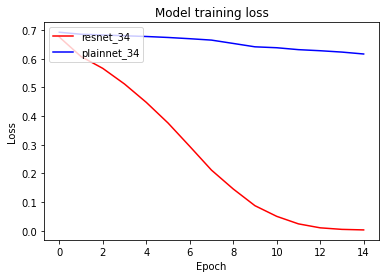

In [46]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')
plt.show()

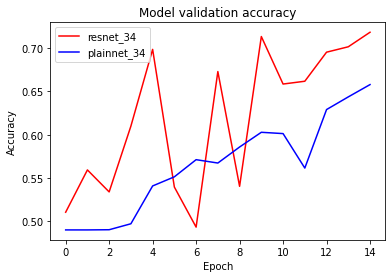

In [47]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')
plt.show()

### resnet_50과 plainnet_50 비교하기

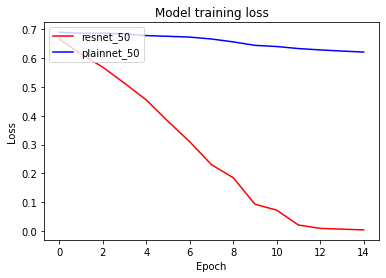

In [48]:
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'], loc='upper left')
plt.show()

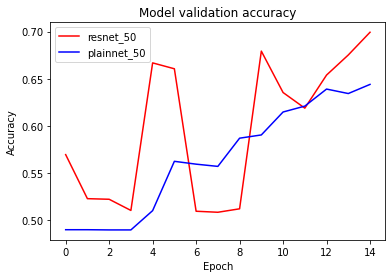

In [49]:
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'], loc='upper left')
plt.show()

## 회고
- 이미지셋을 cats_vs_dogs로 학습했다
- cats_vs_dogs의 이미지셋은 url로 다운받았다
- (32,32,3)은 한 모델 학습하는데 5분 정도 였다면 (224, 224, 3)은 그에 비해 아주 오래 걸렸다
- loss는 큰 차이라고 생각하지 않았는데 acc가 큰 차이를 보였다